In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nemesispy.common.info_mol_id import mol_id
from nemesispy.common.constants import *
import os
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.radtran.calc_mmw import calc_mmw

import spectres

# Loading

#### Loading in .ref/.prf file

Add whatever columns you need

In [2]:
prf_header = ['height', 'press', 'temp', 'h2o', 'co2', 'co', 'ch4', 'h2', 'he', 'na', 'k']
prf = pd.read_csv('./example_data/hd189.prf', skiprows=11, header=None, sep='\s+')
prf.columns = prf_header
print(prf.head())
H_model = prf['height'].values * 1e3
P_model = prf['press'].values * ATM
T_model = prf['temp'].values
VMR_model = prf[['h2o', 'co2', 'co', 'ch4','na','k', 'h2', 'he']].values
NLAYER = len(P_model) # Number of layers

     height  press    temp     h2o     co2      co     ch4     h2      he  \
0     0.000  25.00  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
1   297.764  15.00  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
2   549.673   9.87  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
3   785.191   7.16  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   
4  1011.136   5.47  2250.0  0.0001  0.0001  0.0001  0.0001  0.901  0.0991   

         na             k  
0  0.000005  1.000000e-07  
1  0.000005  1.000000e-07  
2  0.000005  1.000000e-07  
3  0.000005  1.000000e-07  
4  0.000005  1.000000e-07  


#### Loading in planet spectrum

[0.043 0.048 0.043 0.043 0.045]


<ErrorbarContainer object of 3 artists>

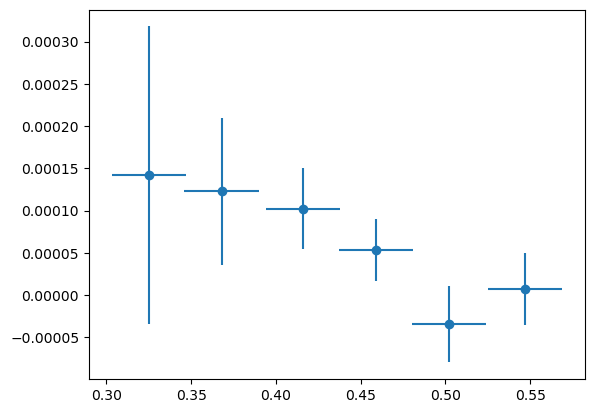

In [3]:
planet_spec = pd.read_csv('./example_data/hd189_data.txt', header=None, sep='\s+')
planet_wave = planet_spec[0].values
planet_flux = planet_spec[1].values
planet_err = planet_spec[2].values
print(np.diff(planet_wave))
plt.errorbar(planet_wave, planet_flux, yerr=planet_err, xerr=0.022, fmt='o')

#### Loading in stellar spectrum

If your spectrum is in watts (luminosity), need to divide by 4pi. This will be applicable if you're using a sol file compatible with NEMESIS.

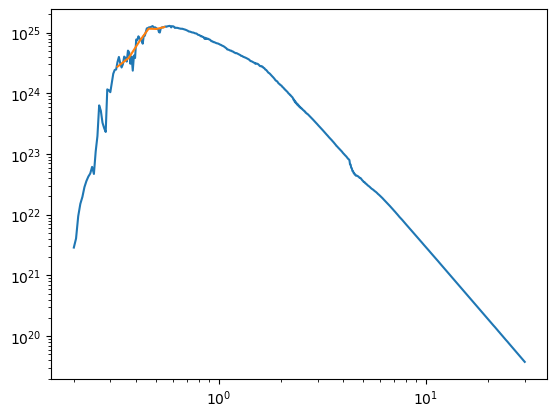

In [4]:

st_spec = pd.read_csv('./example_data/hd189.dat', skiprows=3, header=None, sep='\s+')
st_wave_full = st_spec[0].values
st_flux_full = st_spec[1].values / (4*np.pi) # Check this!
st_wave = planet_wave.copy()
st_flux = spectres.spectres(planet_wave, st_wave_full, st_flux_full)
plt.loglog(st_wave_full, st_flux_full)
plt.loglog(st_wave, st_flux)
# plt.gca().set_xscale('log')

#### Other parameters

Specify wavelengths, the resolution of the disc average, mass and radius of the planet, what gases you're using, and the opacity table paths.

In [5]:
# Wavelengths grid for the spectrum (microns)
wave_grid = planet_wave
nwave = len(wave_grid)

# Pick resolution for the disc average
nmu = 5 # Number of mu bins

# Reference planetary parameters
M_plt = 2167.664 * 1e24
R_plt = 84592.31 * 1e3 # m

# List of gas species to include in the model using identifiers
gas_names_active = ['H2O', 'CO2', 'CO', 'CH4','Na','K']
nvmr = len(gas_names_active)

# Spectrally inactive gases to include
gas_names_inactive = ['H2', 'He']
gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id) # Isotopologue identifier


lowres_file_paths = [f'{gas}_hd189_refl.kta' for gas in gas_names_active]
__location__ = '.'
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')

In [6]:
    # Create a ForwardModel object
FM = ForwardModel()
FM.set_planet_model(
    M_plt=M_plt,R_plt=R_plt,
    gas_id_list=gas_id,iso_id_list=iso_id,
    NLAYER=NLAYER
    )
FM.set_opacity_data(
    kta_file_paths=lowres_file_paths,
    cia_file_path=cia_file_path
)
print(lowres_file_paths)

['./nemesispy/data/ktables/H2O_hd189_refl.kta', './nemesispy/data/ktables/CO2_hd189_refl.kta', './nemesispy/data/ktables/CO_hd189_refl.kta', './nemesispy/data/ktables/CH4_hd189_refl.kta', './nemesispy/data/ktables/Na_hd189_refl.kta', './nemesispy/data/ktables/K_hd189_refl.kta']


# Forward model analysis

We want to vary metallicity, a cloud parameterisation, and what the cloud is comprised of. 

First, we will define a (placeholder) function that takes a metallicity parameter and returns a modified VMR model.

In [7]:
print(gas_id)

[ 1  2  5  6 60 61 39 40]


In [8]:
def metallicity_to_VMR(metallicity, original_VMR_model):
    # Link this to a chemical model, or something else
    # As a placeholder, we'll just scale all the gases except H2 and He
    VMR_model = original_VMR_model.copy()
    VMR_model[:,:6] = VMR_model[:,:6] * metallicity
    return VMR_model

Next up is the cloud parameterisation. We'll do something like model 9 in NEMESIS. This is very rough and was written quickly, so you might want to check it/write your own. In particular, the opacity will probably be quite off. But I'm assuming you want to use an optically thick cloud in which case you can just set it high.

In [29]:
from scipy.integrate import simpson

def cloud_top_pressure_to_A(VMR_model,
                            cloud_top_pressure, 
                            opacity = 10.0,
                            fsh = 1.0):
    
    A_model = np.zeros_like(P_model)
    
    cloud_top_height = np.interp(np.log(cloud_top_pressure),np.log(P_model[::-1]),H_model[::-1])
    
    
    
    grav = G*M_plt/((R_plt+H_model)**2)
    molwt = calc_mmw(gas_id, VMR_model.T)    
    
    scale = K_B* T_model / (molwt * grav)

    for i in np.where(H_model > cloud_top_height)[0]:
        if A_model[i-1] == 0:
            A_model[i] = 1
            continue

        A_model[i] = A_model[i-1] * np.exp(-(H_model[i] - H_model[i-1])/(scale[i]*fsh))
    A_model = A_model*(opacity/simpson(A_model,x=H_model))*1e4
        
    #A_model has to be shape (NLAYER,NMODES)
    A_model = A_model[:,None]
    return A_model

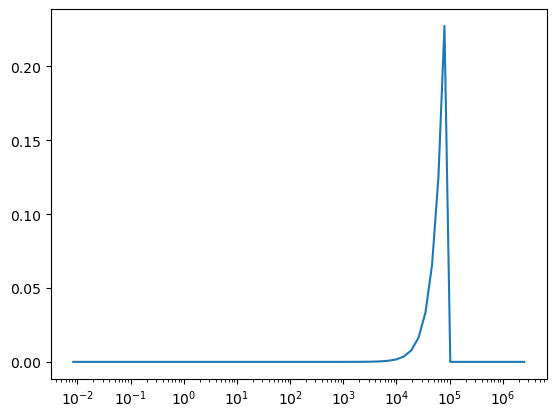

In [30]:
plt.plot(P_model,cloud_top_pressure_to_A(VMR_model,1e5))
plt.xscale('log')

Now let's write a function that takes a path to a text file containing the real and imaginary refractive index spectrum for some aerosol.

In [31]:
def aerosol_path_to_forward_model(path, forward_model,
                                 mean_size = 0.05,
                                 size_variance = 0.05):
    
    aerosol = pd.read_csv(path, skiprows=2, header=None, sep='\s+')
    
    wave = aerosol[0].values
    n_real = aerosol[1].values
    n_imag = aerosol[2].values
    
    # Setting up phase function
    
    forward_model.clear_phase_function()
    
    n_imag_wave_grid = wave

    n_imag =  n_imag
    n_real = n_real

    forward_model.add_phase_function(mean_size = mean_size, 
                          size_variance = size_variance, 
                          n_imag = n_imag, 
                          n_imag_wave_grid = n_imag_wave_grid, 
                          n_real_reference = n_real,
                          n_real_reference_wave= wave_grid.min(),
                          iscat = 1)
    return forward_model

Let's test this and see what it looks like.

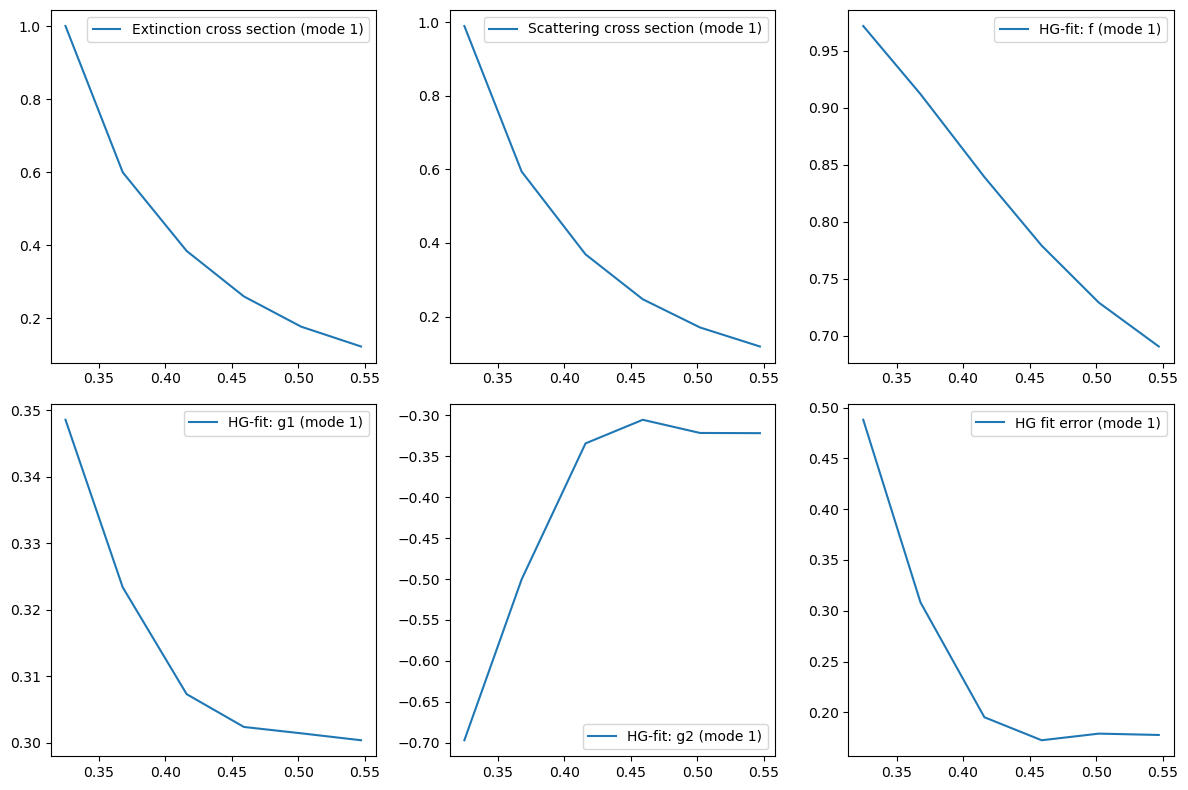

In [32]:
FM = aerosol_path_to_forward_model('./example_data/enstatite.dat',FM)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
parameters = ['Extinction cross section','Scattering cross section',
              'HG-fit: f','HG-fit: g1','HG-fit: g2','HG fit error']
for i in range(6):
    row = i // 3
    col = i % 3
    axs[row, col].plot(FM.wave_grid, FM.phase_func[:, :, i].transpose())
    axs[row, col].legend([f'{parameters[i]} (mode 1)', f'{parameters[i]} (mode 2)'])

plt.tight_layout()
plt.show()

Now we can run our forward model analysis. You might want to parallelise over one of the loops if it's taking too long. It will take a minute or so to start running for the first time.

In [33]:
import sys

phase_angle = 0

n_steps = 10

metallicities = 10**np.linspace(0,3,n_steps)
cloud_top_pressures = 10**np.linspace(2,-3,n_steps) * 101325
aerosol_paths = ['./example_data/enstatite.dat']

print(f"Min, Max metallicity: {metallicities.min(),metallicities.max()}")
print(f"Min, Max cloud top pressures (bar): {cloud_top_pressures.min()/101325,cloud_top_pressures.max()/101325}")
      

chisq_grid = np.zeros(((len(aerosol_paths),len(metallicities),len(cloud_top_pressures))))

for iap, ap in enumerate(aerosol_paths):
    
    FM = aerosol_path_to_forward_model(ap,FM)
    
    for im, m in enumerate(metallicities):
        
        adjusted_VMR_model = metallicity_to_VMR(m , VMR_model)
        
        for ictp, ctp in enumerate(cloud_top_pressures):

            A_model = cloud_top_pressure_to_A(adjusted_VMR_model, ctp)

            spec_out = FM.calc_disc_spectrum_uniform(phase = phase_angle,
                                          nmu = nmu,
                                          P_model = P_model,
                                          T_model = T_model,
                                          VMR_model = adjusted_VMR_model,
                                          solspec = st_flux,
                                          A_model = A_model
                                  )
            chisq = ((spec_out - planet_flux)**2/planet_err**2).mean()
            chisq_grid[iap,im,ictp] = chisq      
            
            output = f"Chisq: {chisq:.2f}, Metallicity: {m:.2e}, Cloud top pressure (bar): {ctp/101325:.2e}, Path: {ap}, Spectrum: {ictp+im*n_steps+iap*n_steps*n_steps+1}/{chisq_grid.size}"
            sys.stdout.write(f"\r{output.ljust(800)}") 
            sys.stdout.flush()


Min, Max metallicity: (1.0, 1000.0)
Min, Max cloud top pressures (bar): (0.001, 100.0)
Chisq: 0.76, Metallicity: 1.00e+03, Cloud top pressure (bar): 1.00e-03, Path: ./example_data/enstatite.dat, Spectrum: 99/100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

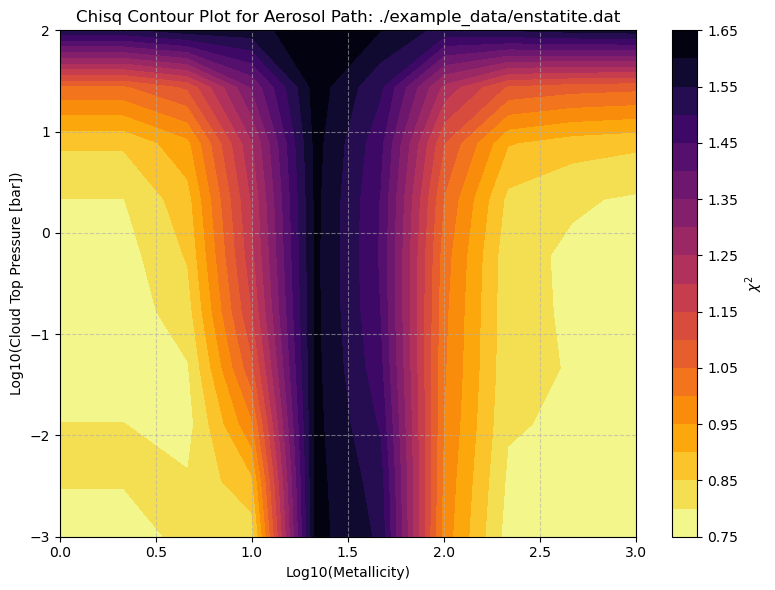

In [34]:
for iap, ap in enumerate(aerosol_paths):
    X, Y = np.meshgrid(np.log10(metallicities), np.log10(cloud_top_pressures / 101325)) 
    Z = chisq_grid[iap]

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='inferno_r')
    plt.colorbar(contour, label=r'$\chi^2$')

    plt.title(f'Chisq Contour Plot for Aerosol Path: {ap}')
    plt.xlabel('Log10(Metallicity)')
    plt.ylabel('Log10(Cloud Top Pressure [bar])')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()